# California Weather Data Exploration

**Dataset**: NOAA GHCN Daily Weather Data (California)  
**Date Range**: 2020 - 2025  
**Source**: NOAA Climate Data Online API

**Objective**: 
- Explore California weather station data
- Analyze temperature and precipitation patterns
- Understand weather conditions during January 2025 fires
- Identify key weather features for fire prediction model


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. Load Weather Data


### Dataset Columns Explained

The NOAA weather dataset contains the following columns:

1. **date**: Date of measurement (format: YYYY-MM-DDTHH:MM:SS)
2. **datatype**: Type of weather measurement (see below for details)
3. **station**: Weather station identifier (format: GHCND:XXXXXXXXX)
4. **attributes**: Quality control metadata (comma-separated flags)
5. **value**: Actual measurement value (units depend on datatype)

#### Attributes Column Breakdown:
The `attributes` column contains quality control information from NOAA:
- Format: `,,quality_flag,measurement_time`
- Example: `,,7,1600` means:
  - Empty fields = no special flags
  - `7` = Data passed 7 quality checks (good quality!)
  - `1600` = Measurement time (4:00 PM in 24-hour format)
- **For ML purposes**: We can ignore this column and use the `value` directly

#### Data Types Available:

| Code | Description | Units | Usage in Fire Prediction |
|------|-------------|-------|--------------------------|
| **TMAX** | Maximum daily temperature | Celsius (°C) | High temps → dry vegetation, higher fire risk |
| **TMIN** | Minimum daily temperature | Celsius (°C) | Temperature range, nighttime conditions |
| **PRCP** | Daily precipitation | Millimeters (mm) | Rain → wet fuels, lower fire risk |

#### Data Source:
- **API**: [NOAA Climate Data Online (CDO)](https://www.ncdc.noaa.gov/cdo-web/)
- **Dataset**: GHCND (Global Historical Climatology Network - Daily)
- **Documentation**: [GHCND Documentation](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily)
- **API Docs**: [CDO Web Services](https://www.ncdc.noaa.gov/cdo-web/webservices/v2)


In [2]:
# Load combined weather data
weather_file = Path('../data/raw/weather/california_weather_2020_2025_combined.csv')
stations_file = Path('../data/raw/weather/california_weather_stations.csv')

print(f"Loading weather data from: {weather_file}")
print(f"File exists: {weather_file.exists()}")

weather_df = pd.read_csv(weather_file)
print(f"\n✅ Loaded {len(weather_df):,} weather records!")

# Load station metadata
stations_df = pd.read_csv(stations_file)
print(f"✅ Loaded {len(stations_df):,} weather stations!")

print("\nFirst 5 weather records:")
weather_df.head()


Loading weather data from: ../data/raw/weather/california_weather_2020_2025_combined.csv
File exists: True

✅ Loaded 17,000 weather records!
✅ Loaded 1,000 weather stations!

First 5 weather records:


,date,datatype,station,attributes,value
0,2020-01-01T00:00:00,TMAX,GHCND:USC00040136,",,7,1600",17.2
1,2020-01-01T00:00:00,TMAX,GHCND:USC00040176,",,7,0800",19.4
2,2020-01-01T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",22.2
3,2020-01-01T00:00:00,TMAX,GHCND:USC00040212,",,7,1700",15.0
4,2020-01-01T00:00:00,TMAX,GHCND:USC00040232,",,7,0800",18.3


## 2. Dataset Overview


In [3]:
# Dataset info
print("=" * 80)
print("WEATHER DATASET SUMMARY")
print("=" * 80)
print(f"\nTotal records: {len(weather_df):,}")
print(f"Columns: {weather_df.shape[1]}")
print(f"\nColumn names: {weather_df.columns.tolist()}")

# Data types
print("\n\nData types and missing values:")
info_df = pd.DataFrame({
    'Column': weather_df.columns,
    'Data Type': weather_df.dtypes,
    'Non-Null': weather_df.count(),
    'Null': weather_df.isnull().sum(),
    'Null %': (weather_df.isnull().sum() / len(weather_df) * 100).round(2)
})
info_df


WEATHER DATASET SUMMARY

Total records: 17,000
Columns: 5

Column names: ['date', 'datatype', 'station', 'attributes', 'value']


Data types and missing values:


,Column,Data Type,Non-Null,Null,Null %
date,date,object,17000,0,0.0
datatype,datatype,object,17000,0,0.0
station,station,object,17000,0,0.0
attributes,attributes,object,17000,0,0.0
value,value,float64,17000,0,0.0


## 3. Weather Data Types & Coverage


Weather Data Types Available:
TMAX    6000
PRCP    6000
TMIN    5000
Name: datatype, dtype: int64


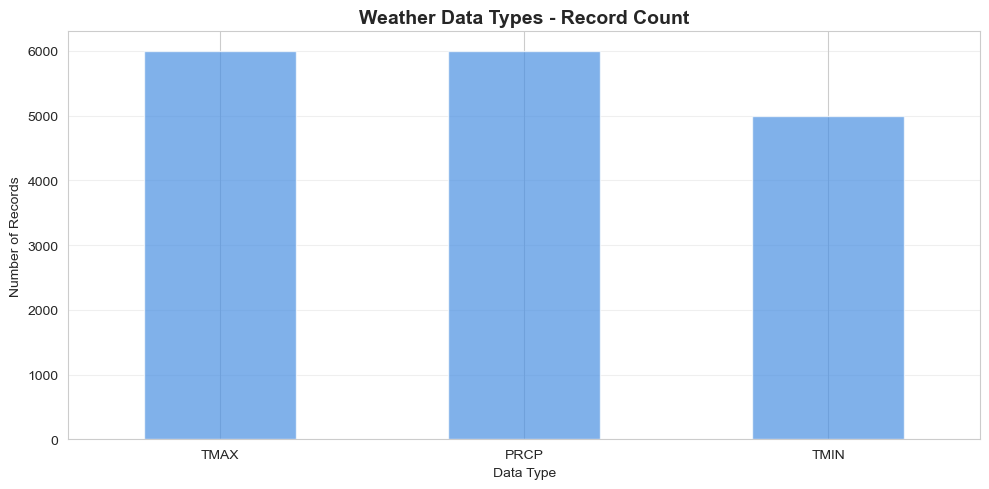



Date Range by Data Type:
TMAX: 2020-01-01 to 2025-01-02
TMIN: 2020-01-01 to 2024-01-02
PRCP: 2020-01-01 to 2025-01-02


In [4]:
# Parse dates
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Weather data types
print("Weather Data Types Available:")
datatype_counts = weather_df['datatype'].value_counts()
print(datatype_counts)

# Plot
plt.figure(figsize=(10, 5))
datatype_counts.plot(kind='bar', color='#4A90E2', alpha=0.7)
plt.title('Weather Data Types - Record Count', fontsize=14, fontweight='bold')
plt.xlabel('Data Type')
plt.ylabel('Number of Records')
plt.xticks(rotation=0)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Date range per data type
print("\n\nDate Range by Data Type:")
for dtype in weather_df['datatype'].unique():
    dtype_data = weather_df[weather_df['datatype'] == dtype]
    print(f"{dtype}: {dtype_data['date'].min().date()} to {dtype_data['date'].max().date()}")


## 4. January 2025 Weather Analysis 🔥


In [5]:
# Filter January 2025 weather (when Palisades & Eaton fires occurred)
jan_2025 = weather_df[(weather_df['date'] >= '2025-01-01') & (weather_df['date'] <= '2025-01-31')]
print(f"January 2025 weather records: {len(jan_2025):,}")

# Summary by data type
print("\nJanuary 2025 Weather Summary:")
for dtype in jan_2025['datatype'].unique():
    jan_dtype = jan_2025[jan_2025['datatype'] == dtype]
    print(f"\n{dtype}:")
    print(f"  Records: {len(jan_dtype)}")
    print(f"  Mean value: {jan_dtype['value'].mean():.2f}")
    print(f"  Min value: {jan_dtype['value'].min():.2f}")
    print(f"  Max value: {jan_dtype['value'].max():.2f}")
    
# Show actual January 2025 data
print("\n\nSample of January 2025 data:")
jan_2025.head(10)


January 2025 weather records: 2,000

January 2025 Weather Summary:

TMAX:
  Records: 1000
  Mean value: 14.41
  Min value: -5.00
  Max value: 29.40

PRCP:
  Records: 1000
  Mean value: 3.04
  Min value: 0.00
  Max value: 71.10


Sample of January 2025 data:


,date,datatype,station,attributes,value
15000,2025-01-01,TMAX,GHCND:USC00040136,",,7,1600",22.2
15001,2025-01-01,TMAX,GHCND:USC00040192,",,7,1600",18.3
15002,2025-01-01,TMAX,GHCND:USC00040212,",,7,1700",8.9
15003,2025-01-01,TMAX,GHCND:USC00040332,",,7,0800",6.7
15004,2025-01-01,TMAX,GHCND:USC00040444,",,7,0800",13.3
15005,2025-01-01,TMAX,GHCND:USC00040521,",,7,0900",15.6
15006,2025-01-01,TMAX,GHCND:USC00040673,",,7,0800",18.3
15007,2025-01-01,TMAX,GHCND:USC00040741,",,7,1600",16.1
15008,2025-01-01,TMAX,GHCND:USC00040790,",,7,1500",16.1
15009,2025-01-01,TMAX,GHCND:USC00040798,",,7,",22.8


### Potential ML Features from Weather Data

From these basic weather measurements (TMAX, TMIN, PRCP), we can engineer many predictive features:

#### Temperature-Based Features:
1. **Daily Temperature Range** = TMAX - TMIN (large range indicates dry air)
2. **Average Daily Temperature** = (TMAX + TMIN) / 2
3. **7-day Rolling Average Temperature** (recent heat trend)
4. **30-day Rolling Average Temperature** (longer-term pattern)
5. **Temperature Anomaly** = Current temp - Historical average for that date
6. **Days Above Threshold** (e.g., days > 35°C in past week)
7. **Heat Wave Indicator** (consecutive days with high temps)

#### Precipitation-Based Features:
1. **Days Since Last Rain** (critical! dry fuels = fire risk)
2. **7-day Cumulative Precipitation** (recent moisture)
3. **30-day Cumulative Precipitation** (seasonal moisture)
4. **Precipitation Deficit** = Expected rain - Actual rain
5. **Dry Spell Length** (consecutive days with PRCP = 0)
6. **Wet vs. Dry Season Indicator**

#### Combined Features:
1. **Fire Weather Index** = f(temp, humidity, wind, precip) - standard metric
2. **Drying Index** = High temp + No rain
3. **Seasonal Context** (month, season, day of year)

#### Missing (To Add Later):
- ⏳ **Wind Speed** (Santa Ana winds - critical!)
- ⏳ **Wind Direction** (offshore vs. onshore)
- ⏳ **Relative Humidity** (low humidity = high fire risk)
- ⏳ **Wind Gusts** (fire spread accelerator)

These will be added from ERA5 or other sources in later phases.


## 5. Summary for ML Model


In [6]:
print("=" * 80)
print("WEATHER DATA SUMMARY FOR ML MODEL")
print("=" * 80)

print(f"\n📊 Dataset Size:")
print(f"   Total weather records: {len(weather_df):,}")
print(f"   Date range: {weather_df['date'].min().date()} to {weather_df['date'].max().date()}")
print(f"   Years covered: {weather_df['date'].dt.year.nunique()}")

print(f"\n🌡️ Weather Variables:")
for dtype in weather_df['datatype'].unique():
    count = len(weather_df[weather_df['datatype'] == dtype])
    print(f"   {dtype}: {count:,} records")

print(f"\n📍 Geographic Coverage:")
print(f"   Unique weather stations: {weather_df['station'].nunique():,}")
print(f"   Station metadata available: {len(stations_df):,} stations")

print(f"\n🔥 January 2025 Fire Period:")
print(f"   Weather records for Jan 2025: {len(jan_2025):,}")
print(f"   Covers Palisades & Eaton fires: ✅")

print(f"\n✅ Features Ready for ML Model:")
print(f"   ✅ Max Temperature (TMAX)")
print(f"   ✅ Min Temperature (TMIN)")
print(f"   ✅ Precipitation (PRCP)")
print(f"   ⏳ Wind data (limited availability)")

print(f"\n📝 Next Steps:")
print(f"   1. Match weather stations to fire locations")
print(f"   2. Calculate derived features (temp range, dry days, etc.)")
print(f"   3. Aggregate weather data to daily/weekly summaries")

print("=" * 80)


WEATHER DATA SUMMARY FOR ML MODEL

📊 Dataset Size:
   Total weather records: 17,000
   Date range: 2020-01-01 to 2025-01-02
   Years covered: 6

🌡️ Weather Variables:
   TMAX: 6,000 records
   TMIN: 5,000 records
   PRCP: 6,000 records

📍 Geographic Coverage:
   Unique weather stations: 1,556
   Station metadata available: 1,000 stations

🔥 January 2025 Fire Period:
   Weather records for Jan 2025: 2,000
   Covers Palisades & Eaton fires: ✅

✅ Features Ready for ML Model:
   ✅ Max Temperature (TMAX)
   ✅ Min Temperature (TMIN)
   ✅ Precipitation (PRCP)
   ⏳ Wind data (limited availability)

📝 Next Steps:
   1. Match weather stations to fire locations
   2. Calculate derived features (temp range, dry days, etc.)
   3. Aggregate weather data to daily/weekly summaries
